On this stage we will deep in model building and improving.

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans

#from yellowbrick.regressor import CooksDistance
#from yellowbrick.regressor import ResidualsPlot
#from yellowbrick.cluster.elbow import kelbow_visualizer
#from yellowbrick.cluster import silhouette_visualizer

from sklearn.ensemble import HistGradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

/home/archer/.miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Let's load dataset that we prepared on the EDA stage. Remember, we and some new features, so it is a bit bigger then initial.

In [2]:
#df = pd.read_csv('eda_data.csv').sample(800_000)    # not enought ram to compute all dataset
#df.to_csv('down.csv', index=False)
df = pd.read_csv('down.csv')

In [ ]:
# import data we prepared in EDA
df = pd.read_csv('eda_data.csv')#.sample(800_000)
df

,total_sessions_day0,total_sessions_day1,total_sessions_day3,total_sessions_day7,chapters_finished_day0,chapters_finished_day1,chapters_finished_day3,chapters_finished_day7,chapters_opened_day0,chapters_opened_day1,...,platform,target_sub_ltv_day30,target_iap_ltv_day30,target_ad_ltv_day30,target_full_ltv_day30,year,month,day,day_of_week,country_cluster
0,1.0,1.0,1.0,1.0,0,0,0,0,0,0,...,ios,0.000000,0.000000,0.000000,0.000000,2021,12,3,5,0
1,1.0,1.0,1.0,1.0,0,0,0,0,0,0,...,android,0.000000,0.000000,0.000000,0.000000,2021,12,3,5,1
2,1.0,2.0,2.0,2.0,0,0,0,0,0,0,...,android,0.000000,0.000000,0.000000,0.000000,2021,12,3,5,1
3,1.0,1.0,1.0,1.0,0,0,0,0,0,0,...,ios,0.000000,0.000000,0.000000,0.000000,2021,12,3,5,1
4,1.0,1.0,1.0,1.0,0,0,0,0,0,0,...,android,0.000000,0.000000,0.000000,0.000000,2021,12,3,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1466452,11.0,11.0,11.0,11.0,9,9,9,9,10,10,...,ios,0.000000,4.174198,0.037158,4.211356,2021,12,30,4,1
1466453,2.0,3.0,6.0,7.0,5,9,11,13,6,10,...,ios,4.705161,10.967580,0.091267,15.764008,2021,12,30,4,1
1466454,3.0,5.0,11.0,13.0,5,9,15,18,5,10,...,ios,0.000000,14.938221,0.000000,14.938221,2021,12,30,4,1
1466455,5.0,5.0,5.0,5.0,24,24,24,24,24,24,...,ios,0.000000,7.402224,0.177550,7.579774,2021,12,30,4,1


## Preprocessing
### Missing values
As you can remember we deal with missing values in EDA and remove all NA. So there nothing to do now. But in anothe case, at this case we would have to check all our date for having NaN values and deleted or replace them with zeros. Also it good prartice to check your object values that saved as string, because thay can containe blank string, that could be understand as missing value.

### One Hot Encoding

In [3]:
cat = [col for col in df.columns if df[col].dtype == "O"]
df = pd.get_dummies(df, columns=cat)

In [ ]:
# make list of our categorical features
cat = [col for col in df.columns if df[col].dtype == "O"]
# make one hot encoding of categorical features
df = pd.get_dummies(df, columns=cat)
df

,total_sessions_day0,total_sessions_day1,total_sessions_day3,total_sessions_day7,chapters_finished_day0,chapters_finished_day1,chapters_finished_day3,chapters_finished_day7,chapters_opened_day0,chapters_opened_day1,...,country_code_COUNTRY_92,country_code_COUNTRY_93,country_code_COUNTRY_94,country_code_COUNTRY_95,country_code_COUNTRY_96,country_code_COUNTRY_97,country_code_COUNTRY_98,country_code_COUNTRY_99,platform_android,platform_ios
0,1.0,1.0,1.0,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1.0,1.0,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1.0,2.0,2.0,2.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1.0,1.0,1.0,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1.0,1.0,1.0,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1466452,11.0,11.0,11.0,11.0,9,9,9,9,10,10,...,0,0,0,0,0,0,0,0,0,1
1466453,2.0,3.0,6.0,7.0,5,9,11,13,6,10,...,0,0,0,0,0,0,0,0,0,1
1466454,3.0,5.0,11.0,13.0,5,9,15,18,5,10,...,0,0,0,0,0,0,0,0,0,1
1466455,5.0,5.0,5.0,5.0,24,24,24,24,24,24,...,0,0,0,0,0,0,0,0,0,1


### Scaling

Spoiler: we will use Decision Tree based algorytms, so there no needness to scaling date. But in case we would like to use others, this step is desirable.

## Split dataset

We have very huge datasets, so to keep valid and test sets small enought, let's set their size to be constant.

In [4]:
# split dataset on features and target
X = df.drop(['target_full_ltv_day30', 'target_ad_ltv_day30', 'target_iap_ltv_day30', 'target_sub_ltv_day30'], axis=1)
y = df[['target_full_ltv_day30', 'target_ad_ltv_day30', 'target_iap_ltv_day30', 'target_sub_ltv_day30']].copy()

# creating validation dataset
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=50_000, random_state=42)
# creating train and test dataset
train_X, test_X, train_y, test_y = train_test_split(train_X, train_y, test_size=50_000, random_state=42)

# print datasets sizes
print(f'Train size: X - {train_X.shape}, y - {train_y.shape}')
print(f'Valid size: X - {valid_X.shape}, y - {valid_y.shape}')
print(f'Test size: X - {test_X.shape}, y - {test_y.shape}')

Train size: X - (700000, 299), y - (700000, 4)
Valid size: X - (50000, 299), y - (50000, 4)
Test size: X - (50000, 299), y - (50000, 4)


In [5]:
# delete needless variables to free memory
del df
del X
del y

## Baseline model

To proberly measure improvements of our model we need to have some value that we can consider as baseline, so then we will be able to evaluate model perfomace increase or decrease. Let's take just mean of the target.

In [ ]:
# evaluate baseline
valid_full_mean = np.full(valid_y['target_full_ltv_day30'].shape, valid_y['target_full_ltv_day30'].mean())
baseline = mean_absolute_error(valid_full_mean, valid_y['target_full_ltv_day30'])
print(f'Baseline for MAE metric: {baseline}')

Baseline for MAE metric: 0.48397822372695487


### Metric
As we may remember from EDA, we have 75% user that do not bring any income, most revenur are got from big amount of user with small bill and only very very small part of them bring big money. There are no need to penalize big errors as for as it is more important to make prediction closer to true label at most of the users (small target). MAE  metrics will fit this case perfectly.

Here we create a funciton to try couple of models and print their perfomance on the data. We also will mesuare fit time and prediction time to have more variable to compare models.

In [ ]:
def train_models(models, t_X, t_y, val_X, val_y):
    """This function took list of models and data. It will train them and evalueate some metrics. Return list of examinated metrics.

    Args:
        models (list): list of models to compare
        t_X (pd.DataFrame): dataset of train features
        t_y (pd.DataFrame): dataset of train target
        val_X (pd.DataFrame): dataset of validation features
        val_y (pd.DataFrame): dataset of validation target

    Returns:
        list: array of models with its metrics
    """    
    
    scores = []
    for model in models:
        start = time.time()
        model.fit(t_X, t_y)
        fitting = time.time()
        pred = model.predict(val_X)
        prediction = time.time()

        mape = mean_absolute_percentage_error(val_y, pred)
        mse = mean_squared_error(val_y, pred)
        mae = mean_absolute_error(val_y, pred)
        r2 = r2_score(val_y, pred)
        fit_time = fitting - start
        pred_time = prediction - fitting

        row = [str(model).split('(')[0], mape, mse, mae, r2, fit_time, pred_time]
        print(row)
        scores.append(row)
    
    return scores

As we have highly table-structured datasets, the best way to deal with it is to use boosting or bagging/pasting models. Here we try couple of them to choose the best one for our case. After that we will use some tuning data wragling techniques to improve our score. (We exclude RandomForest, ExtraForest and AdaBoost as it take sometimes 10 times more resources to build model compare to others with same perfomance)

In [ ]:
# create list of model that interest us
models = [HistGradientBoostingRegressor(loss='absolute_error'), xgb.XGBRegressor(eval_metric='mae', verbosity=0), lgb.LGBMRegressor(objective='mae', silent=True)]
# compare that models perfomace
models_scores = train_models(models, train_X, train_y['target_full_ltv_day30'], valid_X, valid_y['target_full_ltv_day30'])

['HistGradientBoostingRegressor', 0.2351, 6.256616992188209, 0.26460065030332547, -0.011316953523239581, 14.3854501247406, 0.03244161605834961]
['XGBRegressor', 11007067863584.018, 0.8823218115057513, 0.08135402026710685, 0.8573818714565387, 280.8991906642914, 0.1234288215637207]
['LGBMRegressor', 1142762164621.149, 2.048958510803377, 0.0788471982598187, 0.6688072033770975, 10.858447551727295, 0.1774590015411377]


In [ ]:
# build DataFrame of models metrics
models_result = pd.DataFrame(models_scores, columns=['Model', 'mape', 'mse', 'mae', 'r2', 'training time', 'predicting time'])
models_result.sort_values('mae')

,Model,mape,mse,mae,r2,training time,predicting time
2,LGBMRegressor,1.142762e+12,2.048959,0.078847,0.668807,10.858448,0.177459
1,XGBRegressor,1.100707e+13,0.882322,0.081354,0.857382,280.899191,0.123429
0,HistGradientBoostingRegressor,2.351000e-01,6.256617,0.264601,-0.011317,14.385450,0.032442


We can notice that LightGBM brings the best MAE score, also it is the fastest model, so we end on this one.

In [ ]:
# evaluate improvement in compare to baseline
baseline / models_result.iloc[-1, 3]

6.138179090804738

We get almost 6 time improvement in compare with baseline score!

## Model analysis

In [ ]:
# build model
model = lgb.LGBMRegressor(objective='mae', n_jobs=-2, random_state=42, verbose=1)
# fit model
model.fit(train_X, train_y['target_full_ltv_day30'])
# make prediciton
pred = model.predict(valid_X)

print(f'MAE score: {mean_absolute_error(valid_y.target_full_ltv_day30, pred)}')
print(f'R2 score: {model.score(valid_X, valid_y.target_full_ltv_day30)}')

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.493241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7167
[LightGBM] [Info] Number of data points in the train set: 700000, number of used features: 209
MAE score: 0.07813220345839915
R2 score: 0.6766510771300726


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


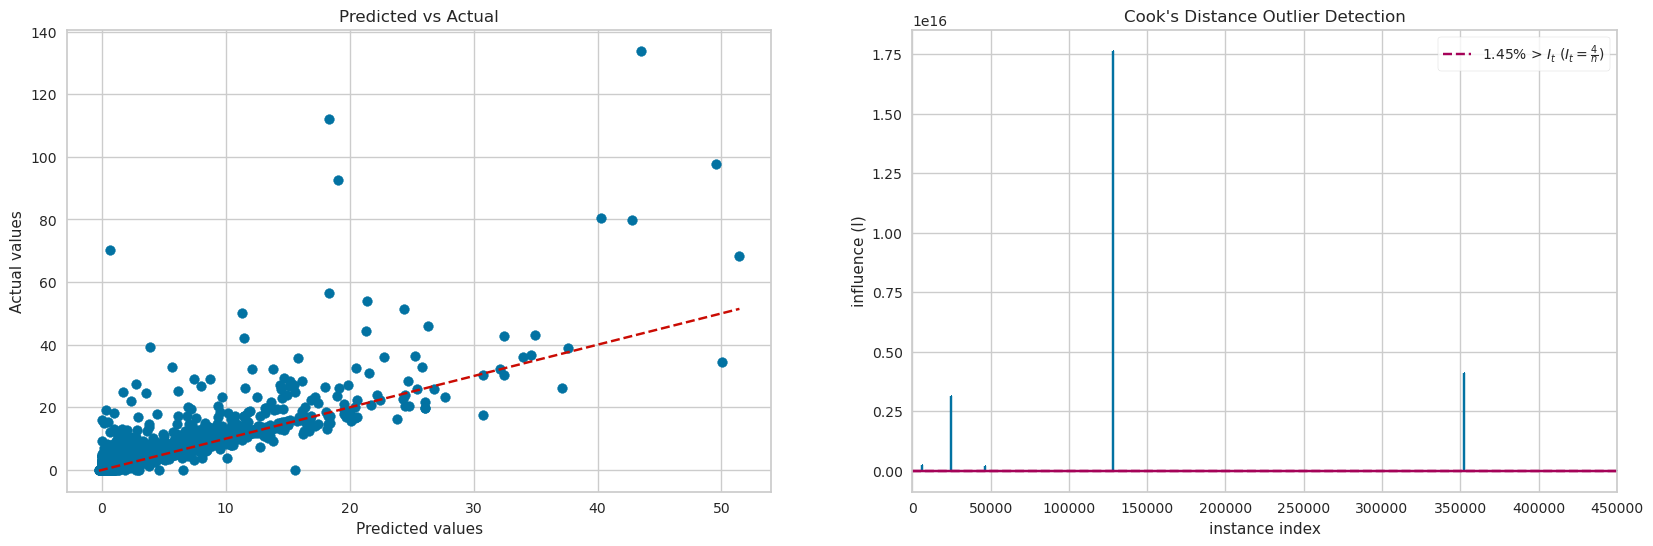

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

# plot prediction to true value scatterplot
ax[0].scatter(pred, valid_y['target_full_ltv_day30'])
ax[0].plot([pred.min(), pred.max()], [pred.min(), pred.max()], 'r--')
ax[0].set_xlabel('Predicted values')
ax[0].set_ylabel('Actual values')
ax[0].set_title('Predicted vs Actual')

# plot Cook's distance plot
visualizer = CooksDistance()
visualizer.fit(train_X, train_y['target_full_ltv_day30'])
ax[1] = visualizer.show()

From Predicted vs Actual plot we can explore that our model <b>perfome badly with hudge target value</b>. This points can be considered as outliers. Let's try to detect and remove some of them and measure new perfomance.

In some cases values with hight Cook's distance may be outliers. Try to fit model without higth influence point and measure its permonce diffence.

In [ ]:
# find outliers index
no_outliers_idx = visualizer.distance_[(visualizer.distance_ < visualizer.influence_threshold_)].index

# build model
model = lgb.LGBMRegressor(objective='mae', n_jobs=-2, random_state=42, verbose=1)
# fit model
model.fit(train_X.loc[no_outliers_idx], train_y['target_full_ltv_day30'].loc[no_outliers_idx])
# make prediciton
pred = model.predict(valid_X)

print(f'MAE score: {mean_absolute_error(valid_y.target_full_ltv_day30, pred)}')
print(f'R2 score: {model.score(valid_X, valid_y.target_full_ltv_day30)}')

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.291464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6616
[LightGBM] [Info] Number of data points in the train set: 443472, number of used features: 186
MAE score: 0.0894548449974243
R2 score: 0.5312053174227951


Unfortunalty, we got poorer perfomance. It seems that in our case point with hight Cook's distance isn't outliers.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


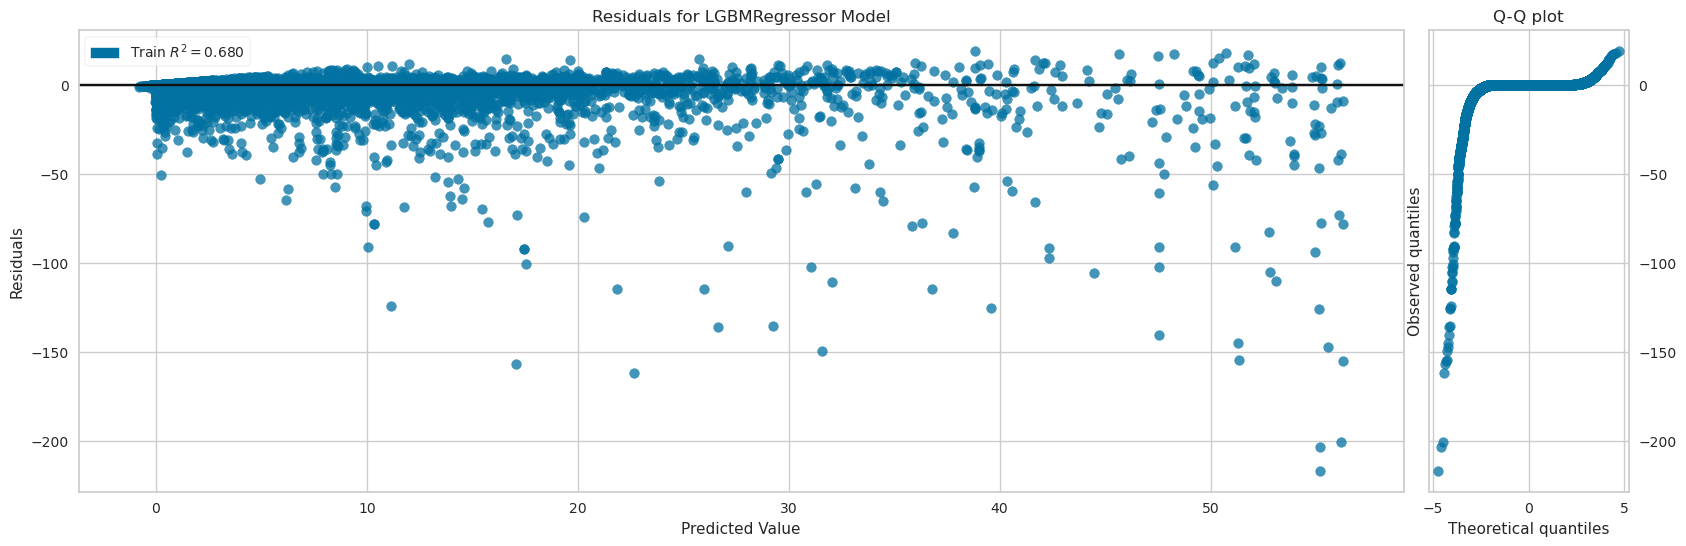

<AxesSubplot:title={'center':'Residuals for LGBMRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [ ]:
plt.figure(figsize=(20, 6))
# plot residual plot and Q-Q plot
visualizer_residuals = ResidualsPlot(model, hist=False, qqplot=True)
visualizer_residuals.fit(train_X, train_y['target_full_ltv_day30'])
visualizer_residuals.show()

Our Residual plot is not clustering towards the middle point, it's asymmetrical and heteroscedastical. It is may be caused of exponential nature of target distrubution. <b>Try to transform target value.</b> From Q-Q plot we can see that our residuals clearly do not have normal nature.

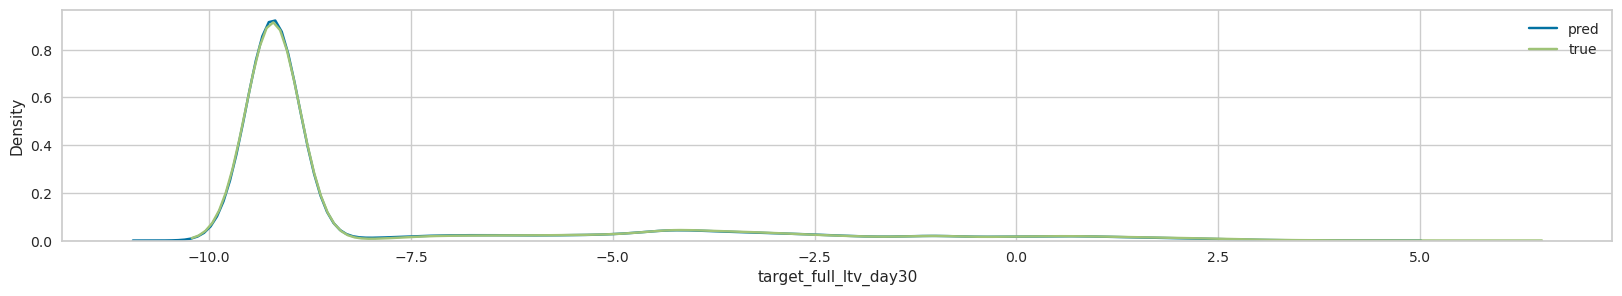

In [ ]:
plt.figure(figsize=(20,3))
# plot distribution of true and predicted values
sns.kdeplot(np.log(pred + 0.0001), label='pred')
sns.kdeplot(np.log(valid_y['target_full_ltv_day30'] + 0.0001), label='true')
plt.legend()
plt.show()

We can see that with log transform distrubution of our true labels and predicted labels are almost the same, some model do its job well. Also distributions look bell-shaped, instist of exponential as it was. Try to build and fit model with such transformation.

In [5]:
# build model
model = lgb.LGBMRegressor(objective='mae', n_jobs=-2, random_state=42, verbose=1)
# fit model
model.fit(train_X, np.log(train_y['target_full_ltv_day30'] + 1), 
          eval_set=[(valid_X, valid_y.target_full_ltv_day30), (train_X, train_y.target_full_ltv_day30)],
          eval_metric='mae', eval_names=['valid', 'train'])
# make prediciton
pred = model.predict(valid_X)

print(f'MAE score: {mean_absolute_error(np.log(valid_y.target_full_ltv_day30 + 1), pred)}')
print(f'R2 score: {model.score(valid_X, np.log(valid_y.target_full_ltv_day30 + 1))}')

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.463320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7167
[LightGBM] [Info] Number of data points in the train set: 700000, number of used features: 209
[1]	valid's l1: 0.263054	train's l1: 0.257717
[2]	valid's l1: 0.261405	train's l1: 0.256096
[3]	valid's l1: 0.25971	train's l1: 0.254435
[4]	valid's l1: 0.258014	train's l1: 0.252765
[5]	valid's l1: 0.255848	train's l1: 0.250624
[6]	valid's l1: 0.253401	train's l1: 0.248219
[7]	valid's l1: 0.250628	train's l1: 0.245491
[8]	valid's l1: 0.247521	train's l1: 0.242469
[9]	valid's l1: 0.242817	train's l1: 0.237822
[10]	valid's l1: 0.238458	train's l1: 0.233515
[11]	valid's l1: 0.234394	train's l1: 0.229532
[12]	valid's l1: 0.230747	train's l1: 0.225946
[13]	valid's l1: 0.227496	train's l1: 0.222761
[14]	valid's l1: 0.224431	train's l1: 0.219735
[15]	valid's l1: 0.22182	train's l1: 0.217179
[16]	valid's

In [ ]:
# evaluate improvement in compare to baseline
baseline / mean_absolute_error(np.log(valid_y.target_full_ltv_day30 + 1), pred)

36.07192270707345

Wow! Get wery significant improvement! Our R2 score increase up to 90 percent, it mean our model can explain up to 90% of variance of dependent variable. Also we get 36 times better perfomance in compare to baseline.

Let's also check if model has hight bias or variance.

<AxesSubplot:title={'center':'Learning curve'}, xlabel='Iterations', ylabel='l1'>

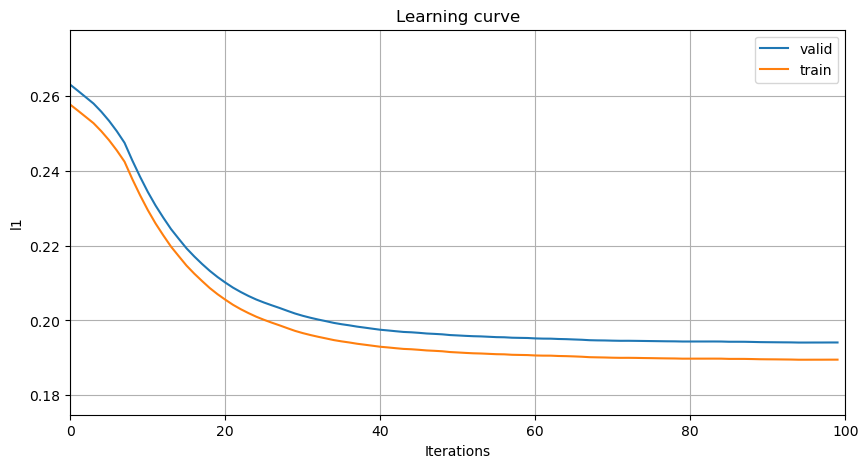

In [9]:
lgb.plot_metric(model, title='Learning curve', figsize=(10,5))

We can clearly see that validation and training score is prety close and model perfomance is well, so overfit or underfit is not noticed.

<b>So, on this step let's make some steps to understand why our model make such decisions.</b>

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

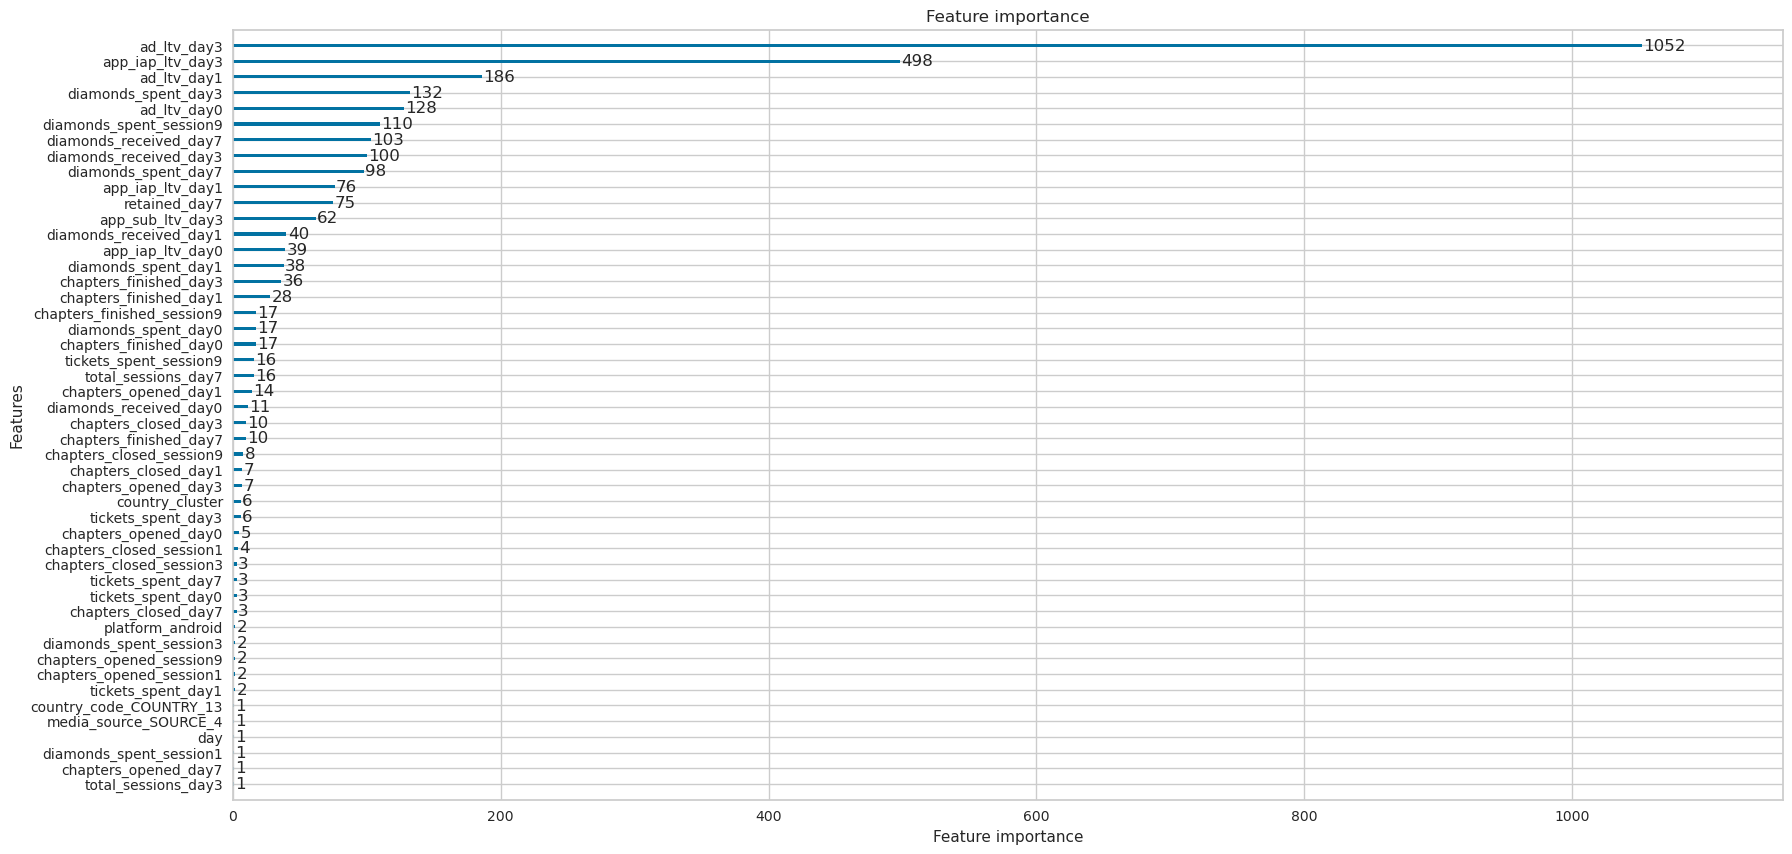

In [ ]:
# plot most important featuares
lgb.plot_importance(model, figsize=(20, 10))

In real business it important for company to understand why model made such decision and ways to improve workflow. For our case, for LightGBM the most important features are ad_ltv_day3 and app_iap_ltv_day3. It means that on 3 day of usage we can clearly undestand the type of our user. Also this features show the level of engagement in product as user buy inner stuff itself or bring revenue via ad.

We also can plot the example of one of the estimators in our LightGMBRegressor.

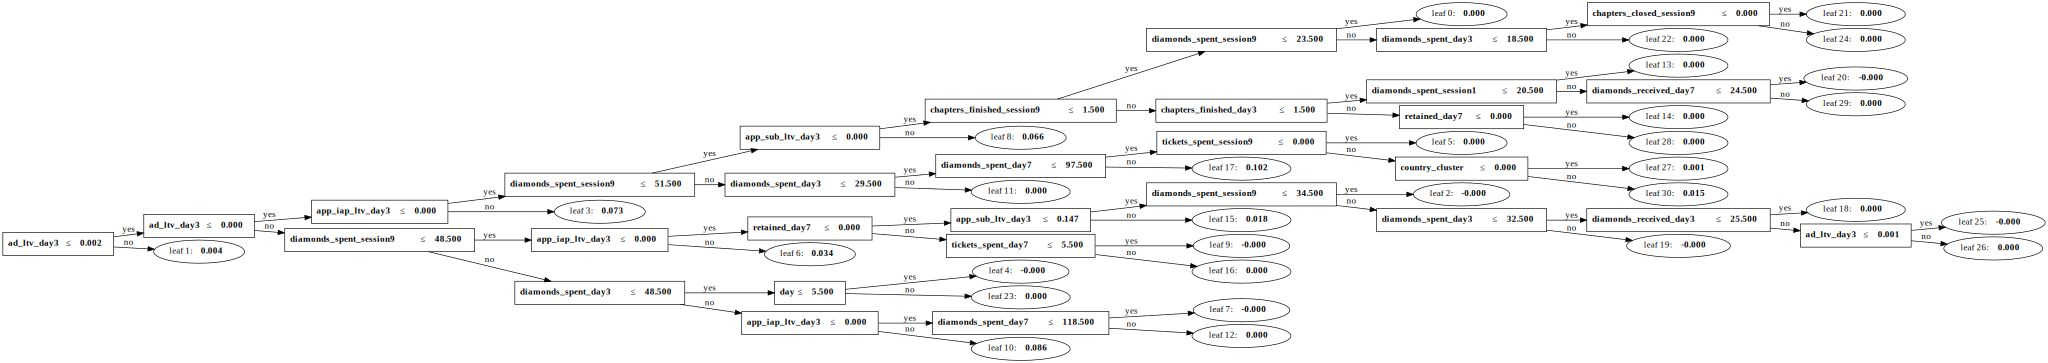

In [ ]:
# plot example of estimator
lgb.create_tree_digraph(model, tree_index=1)

<b>Conclusion:</b>
- cost function is MAE
- model is LightGBM
- normal transform of target is needed
- there are a few important features in dataset

## Dimension Reduction

Our dataset has 299 features and it's quite a lot. As far as our model is dealing fast with task, there are no need in dimension reduction for now. But amount of data can increase in time as we have only two month period and this my case in lower model fitting. So let's try some techniques to reduce number of features in our dataset.

### Sum similar features
As we have features like 'total_sessions_day1', 'total_sessions_day3','total_sessions_day7', we can combine them in only one by summing. Active user still will be have hight score and nonactive - low. Nevertheless, most of our features is hot encoded categories, we can leave only top 15 of them for example.

In [5]:
# list of new features
new_col = ['total_session', 'chapters_finish_day', 'chapters_open_day', 'chapters_close_day', 'diamonds_receiv_day', 
           'diamonds_spend_day', 'tickets_spend_day', 'retension', 'chapters_finish_session', 'chapters_open_session', 
           'chapters_clos_session', 'diamonds_spend_session', 'tickets_spend_session', 'subb_ltv', 'iapp_ltv', 'add_ltv']
# list of partial name of features that will be summed
old_col = ['total_sessions', 'chapters_finished_day', 'chapters_opened_day', 'chapters_closed_day', 'diamonds_received_day', 
           'diamonds_spent_day', 'tickets_spent_day', 'retained', 'chapters_finished_session', 'chapters_opened_session', 
           'chapters_closed_session', 'diamonds_spent_session', 'tickets_spent_session', 'app_sub_ltv', 'app_iap_ltv', 'ad_ltv']

# create new temp dataset
temp_X = pd.DataFrame()
# load our raw data as we changed it
temp_df = pd.read_csv('eda_data.csv')

# sum similar features, put it in new one
for new, old in zip(new_col, old_col):
    temp_X[new] = temp_df[[col for col in temp_df.columns if old in col]].sum(axis=1)

# make one hot encoding of categorical data
ohe = OneHotEncoder(handle_unknown='ignore', max_categories=15, sparse=False)
temp_cat = ohe.fit_transform(temp_df.loc[:, cat])
temp_X = np.concatenate((temp_X.to_numpy(), temp_cat), axis=1)
    
temp_X.shape

(800000, 53)

In [6]:
# creating validation dataset
t_train_X, t_valid_X, t_train_y, t_valid_y = train_test_split(temp_X, y, test_size=50_000, random_state=42)

# print datasets sizes
print(f'Train size: X - {t_train_X.shape}, y - {t_train_y.shape}')
print(f'Valid size: X - {t_valid_X.shape}, y - {t_valid_y.shape}')

Train size: X - (750000, 53), y - (750000, 4)
Valid size: X - (50000, 53), y - (50000, 4)


In [7]:
# build model
model = lgb.LGBMRegressor(objective='mae', n_jobs=-2, random_state=42, verbose=1)
# fit model
model.fit(t_train_X, np.log(t_train_y['target_full_ltv_day30'] + 1))
# make prediciton
pred = model.predict(t_valid_X)

print(f'MAE score: {mean_absolute_error(np.log(t_valid_y.target_full_ltv_day30 + 1), pred)}')
print(f'R2 score: {model.score(t_valid_X, np.log(t_valid_y.target_full_ltv_day30 + 1))}')

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.206922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3061
[LightGBM] [Info] Number of data points in the train set: 750000, number of used features: 53
MAE score: 0.01634897307340602
R2 score: 0.8957591106162759


Well, we get some little improvement in MAE, but lose some points in R2 score, nevertheless they are not significant. However, we reduce our dataset dimension from 299 to 53 and get the same good parfomance. It is a good approach for our case.

### PCA

Another approach to reduce dimension is to choose some unsupervised algorythm. Here I choose Incremental Principal Component Anlysis as only this one can handle such big amount of data on my machine. It is preferable to use KernalPCA, as PCA look only for liniar dependecies, or Isomap or Spectral Embedding.

Text(0.5, 0, 'Principal Component #')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


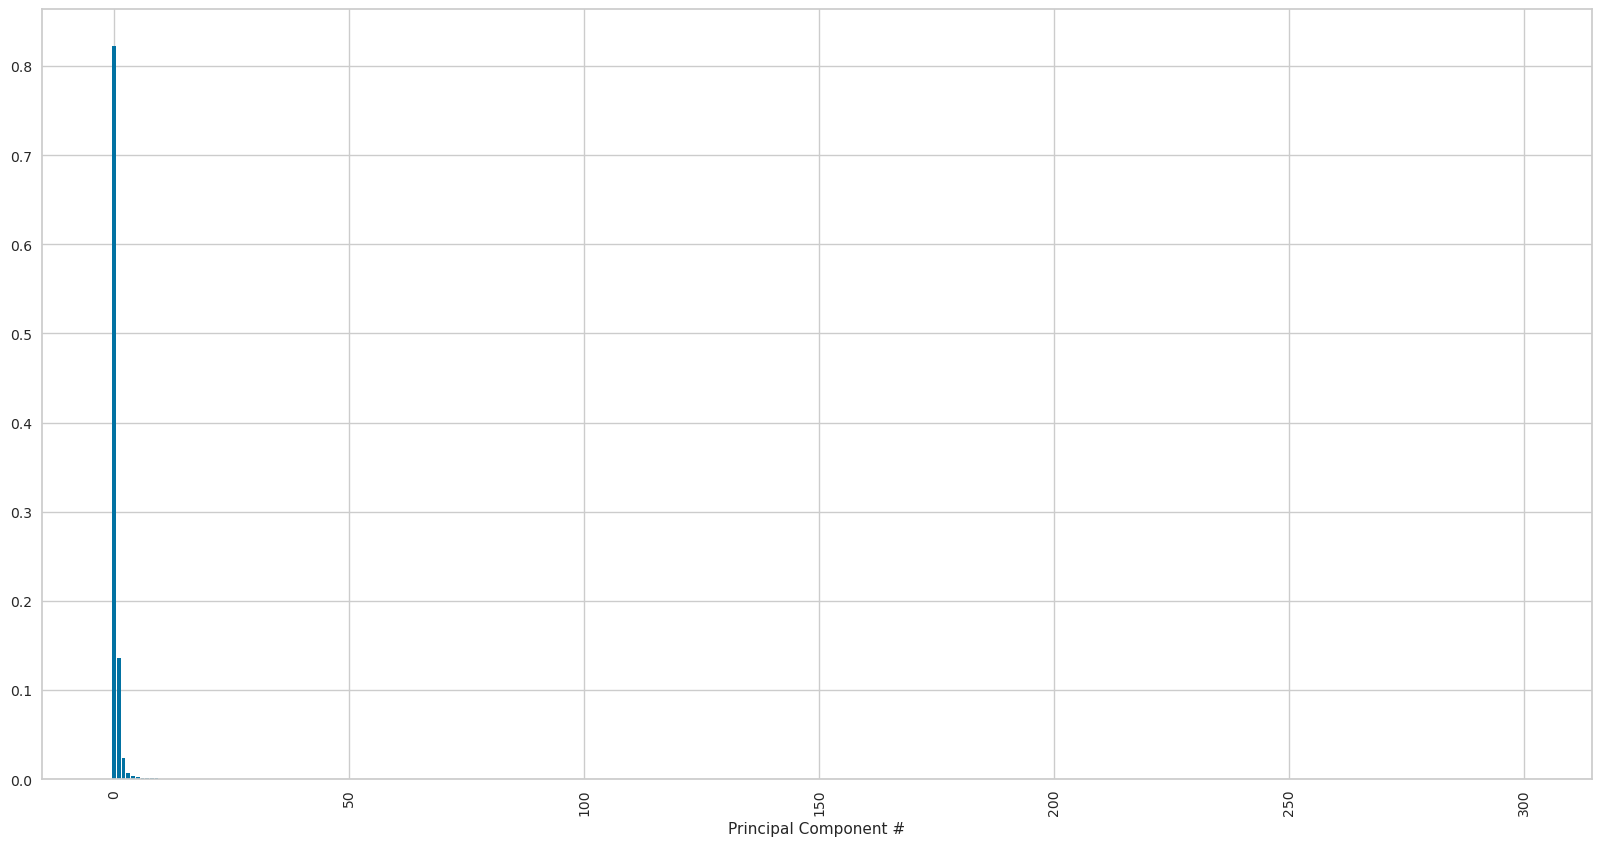

In [6]:
# init pca
pca = IncrementalPCA()
# train pca
train_X_pca = pca.fit_transform(train_X)
# find out how each feature can explain variance of data
exp_variance = pca.explained_variance_ratio_

# plot explained variance ratio
fig, ax = plt.subplots(figsize=(20,10))
plt.xticks(rotation=90)
ax.bar(np.arange(train_X.shape[1]), exp_variance)
ax.set_xlabel('Principal Component #')

From plot above we can see that one of the feature can explain almost 80% of all data and only few of other make some difference. It is mean that for prediction we can use only couple of features and still get good results.

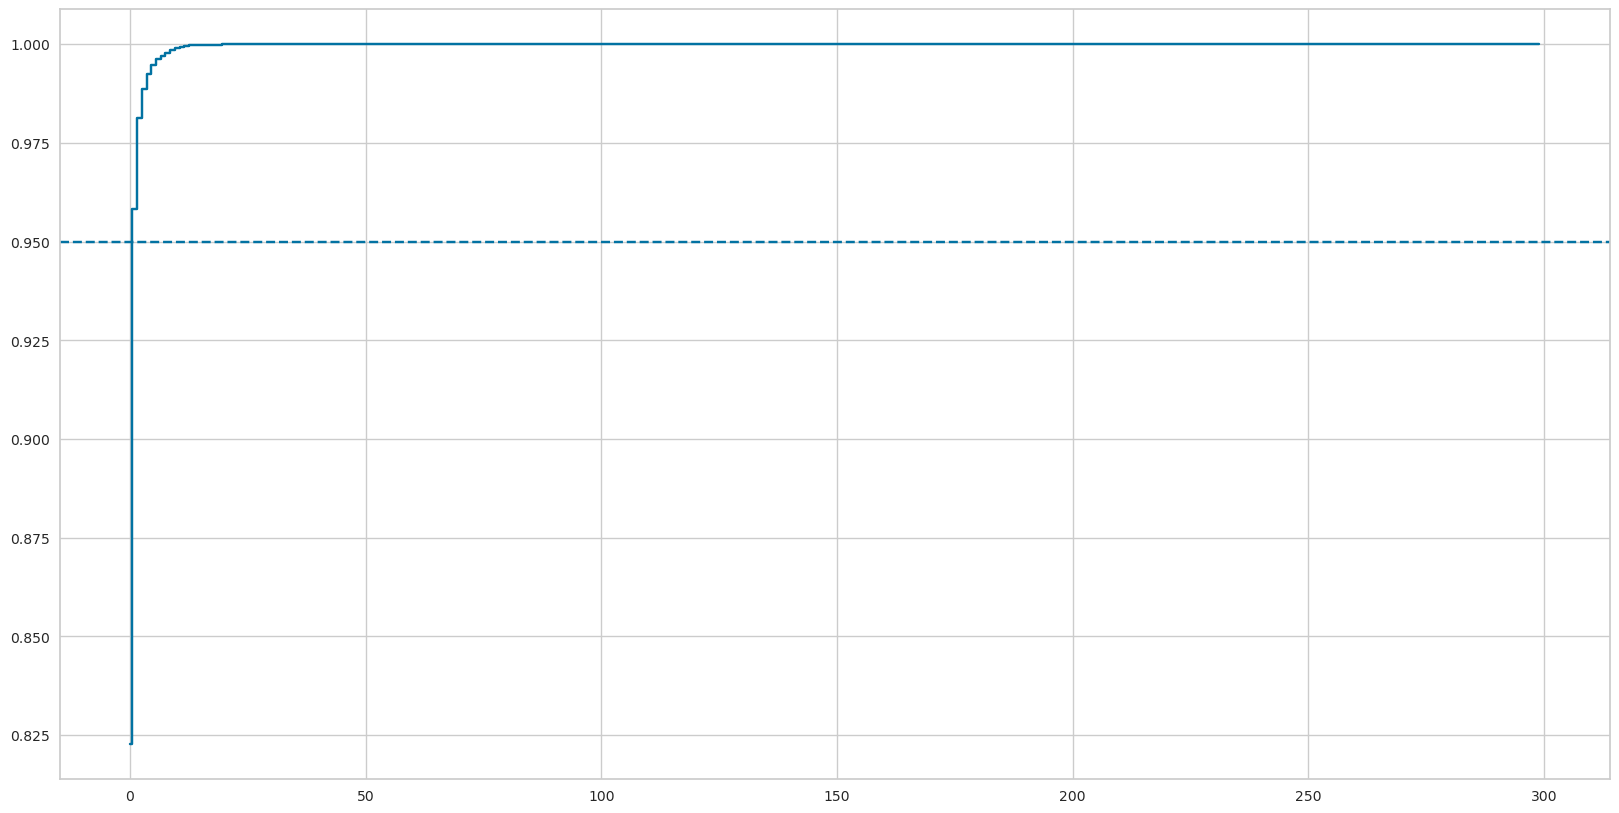

In [7]:
# count cumulative sum
cum_exp_variance = np.cumsum(exp_variance)

# plot cumsum of explained ration
fig, ax = plt.subplots(figsize=(20,10))
plt.step(range(0,len(cum_exp_variance)), cum_exp_variance, where='mid',label='Cumulative explained variance')
ax.axhline(y=0.95, linestyle='--')

Here we build a plot of cumulative sum of feature explanation ratio to see how many of them we need to reach 95% of understaning data variance. (about 20)

In [8]:
# init pca to find only 20 components
pca = IncrementalPCA(n_components=20)
# train pca
train_X_pca = pca.fit_transform(train_X)
valid_X_pca = pca.transform(valid_X)

# build model
model = lgb.LGBMRegressor(objective='mae', n_jobs=-2, random_state=42, verbose=1)
# fit model
model.fit(train_X_pca, np.log(train_y['target_full_ltv_day30'] + 1))
# make prediciton
pred = model.predict(valid_X_pca)

print(f'MAE score: {mean_absolute_error(np.log(valid_y.target_full_ltv_day30 + 1), pred)}')
print(f'R2 score: {model.score(valid_X_pca, np.log(valid_y.target_full_ltv_day30 + 1))}')

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 500000, number of used features: 20
MAE score: 0.03086982367576447
R2 score: 0.8287548138101921


In [9]:
# evaluate improvement in compare to baseline
baseline / mean_absolute_error(np.log(valid_y.target_full_ltv_day30 + 1), pred)

15.678036545019866

By reducing dimension form 299 to 20 we stil get good perfomance! We get exellent MAE score 0.03 and good R2 score 82%. We can consider this as good aproach.

### T-SNE

In EDA part we mention that where group of sources and countries where user behaive much different then other. Let's try to visualize this via t-SNE and hopfully find some patterns.

<AxesSubplot:>

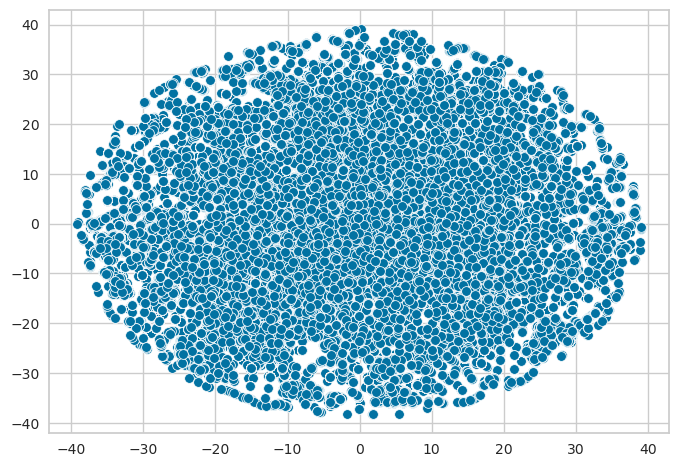

In [8]:
# init t-SNE
tsne = TSNE(n_jobs=-2, random_state=42, verbose=2)
# train t-SNE
train_X_tsne = tsne.fit_transform(train_X.sample(300_000))

# visiualizate result of t-SNE
sns.scatterplot(x=train_X_tsne[:, 0], y=train_X_tsne[:, 1])

Unfortunatelly, we cannot see clear patter. Except that we have clear border of our circle, that can be our target user, but visualization not defined anought.

<b>Conclusion</b>:
- we do not lose perfomance while summing features
- there are spece to successefully reduce dimension of dataset with good perfomance
- PCA is good algorythm for this task, but more complex ones is preferable
- we cannot clearly visualize or dataset in 2D space

## Clustering

As far as our product use different user from different countries and devices we can group them is cluster and fit to model only one of the cluster, so it can better understand each group of user. But at first let's understand how much of this cluster we have to have.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


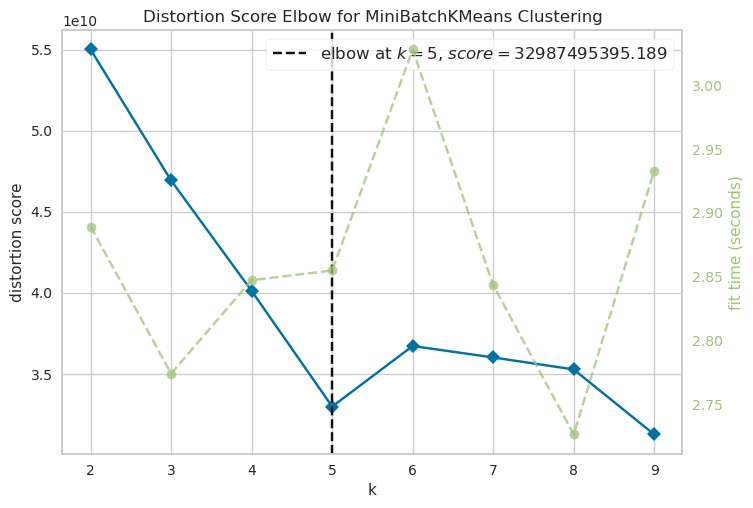

KElbowVisualizer(ax=<AxesSubplot:title={'center':'Distortion Score Elbow for MiniBatchKMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=MiniBatchKMeans(n_clusters=9, random_state=42),
                 k=(2, 10))

In [8]:
#kmeans_per_k = [MiniBatchKMeans(n_clusters=k, random_state=42).fit(train_X) for k in range(1, 10)]
#inertias = [model.inertia_ for model in kmeans_per_k]
#
#plt.figure(figsize=(8, 3.5))
#plt.plot(range(1, 10), inertias, "bo-")
#plt.xlabel("$k$")
#plt.ylabel("Inertia")
#plt.annotate("", xy=(2, inertias[1]), xytext=(2.85, inertias[1] * 1.1),
#             arrowprops=dict(facecolor='black', shrink=0.2))
#plt.text(2.85, inertias[1] * 1.1, "Elbow", horizontalalignment="center")
#plt.grid()
#plt.show()

kelbow_visualizer(MiniBatchKMeans(random_state=42), train_X, k=(2,10))

From the elbow method we can understand that there are most possible 5 different type of users. As we as I understand, silhoette score is good metric to measure quality of data clustering, but as far as me have dataset with over million samples it is hard to use it, that while in plot above distortion score implemented.

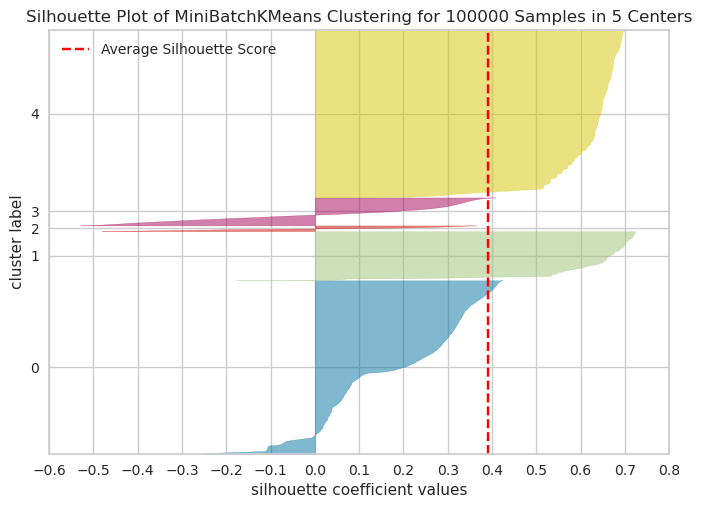

SilhouetteVisualizer(ax=<AxesSubplot:title={'center':'Silhouette Plot of MiniBatchKMeans Clustering for 100000 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     colors='yellowbrick',
                     estimator=MiniBatchKMeans(n_clusters=5, random_state=42))

In [13]:
#from sklearn.metrics import silhouette_samples
#from matplotlib.ticker import FixedLocator, FixedFormatter
#
#plt.figure(figsize=(11, 9))
#
#for k in (2, 3, 4, 5):
#    plt.subplot(2, 2, k - 1)
#    
#    y_pred = kmeans_per_k[k - 1].labels_
#    silhouette_coefficients = silhouette_samples(train_X, y_pred)
#
#    padding = len(train_X) // 30
#    pos = padding
#    ticks = []
#    for i in range(k):
#        coeffs = silhouette_coefficients[y_pred == i]
#        coeffs.sort()
#
#        color = plt.cm.Spectral(i / k)
#        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
#                          facecolor=color, edgecolor=color, alpha=0.7)
#        ticks.append(pos + len(coeffs) // 2)
#        pos += len(coeffs) + padding
#
#    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
#    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
#    if k in (3, 5):
#        plt.ylabel("Cluster")
#    
#    if k in (5, 6):
#        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
#        plt.xlabel("Silhouette Coefficient")
#    else:
#        plt.tick_params(labelbottom=False)
#
#    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
#    plt.title(f"$k={k}$")
#
#plt.show()

silhouette_visualizer(MiniBatchKMeans(n_clusters=5, random_state=42), train_X.sample(100_000), colors='yellowbrick') # use only part of data as it computationly expensive

In [7]:
# find our clusters
kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
train_X_clst = kmeans.fit_predict(train_X)
valid_X_clst = kmeans.predict(valid_X)

# prepare our prediction DataFrame
pred = valid_y.target_full_ltv_day30.copy()
# build model
model = lgb.LGBMRegressor(objective='mae', n_jobs=-2, random_state=42, verbose=1)
for clst in np.arange(kmeans.n_clusters):
    # find elements of same clusters
    train_idx = np.argwhere(train_X_clst == clst).flatten()
    valid_idx = np.argwhere(valid_X_clst == clst).flatten()
    # fit model
    model.fit(train_X.iloc[train_idx], np.log(train_y['target_full_ltv_day30'] + 1).iloc[train_idx])
    # make prediciton
    pred.iloc[valid_idx] = model.predict(valid_X.iloc[valid_idx])

print(f'MAE score: {mean_absolute_error(np.log(valid_y.target_full_ltv_day30 + 1), pred)}')
print(f'R2 score: {r2_score(np.log(valid_y.target_full_ltv_day30 + 1), pred)}')

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6328
[LightGBM] [Info] Number of data points in the train set: 34543, number of used features: 118
[LightGBM] [Info] Start training from score 0.209923
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6875
[LightGBM] [Info] Number of data points in the train set: 4490, number of used features: 84
[LightGBM] [Info] Start training from score 2.570853
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.164660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1881
[LightGBM] [Info] Number of data points in the 

In [10]:
# evaluate improvement in compare to baseline
baseline / mean_absolute_error(np.log(valid_y.target_full_ltv_day30 + 1), pred)

41.20290651499536

Here we get another improvement! More likely, that spliting date on cluster and training model on different cluster helps to better understand our data. Now our model perfome 41 times better that baseline and on 6 point better then previous improvement.

The last that we will try with clusters is to find about 60 clusters in our dataset and train model on this information about clusters. If we have a lot of group with almost similar charachteristic, this will help better fit data.

In [8]:
kmeans = MiniBatchKMeans(n_clusters=60, random_state=42)
t_X_clst = kmeans.fit_transform(train_X)
val_X_clst = kmeans.transform(valid_X)

# build model
model = lgb.LGBMRegressor(objective='mae', n_jobs=-2, random_state=42, verbose=1)
# fit model
model.fit(t_X_clst, np.log(train_y['target_full_ltv_day30'] + 1))
# make prediciton
pred = model.predict(val_X_clst)

print(f'MAE score: {mean_absolute_error(np.log(valid_y.target_full_ltv_day30 + 1), pred)}')
print(f'R2 score: {model.score(val_X_clst, np.log(valid_y.target_full_ltv_day30 + 1))}')

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.157305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15300
[LightGBM] [Info] Number of data points in the train set: 700000, number of used features: 60
MAE score: 0.0384074511866927
R2 score: 0.7644960225811808


Get good result, but unfortunately not better that our previous attemps. Also it take more time to fit, because clustering step is needed.

<b>Conclusions:</b>
- summing of features do not harm perfomance
- splitting data in 5 clusters and prediciton each separately increase perfomance

## Predict each target separately
In preword to our task we get information that our 'target_full_ltv_day30' consist of just summed three components 'target_ad_ltv_day30', target_iap_ltv_day30', 'target_sup_ltv_day30'. We can build three separate model and add their prediction. It may help to find out different patterns for different target.

In [16]:
# find our clusters
kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
train_X_clst = kmeans.fit_predict(train_X)
valid_X_clst = kmeans.predict(valid_X)

# prepare our prediction DataFrame
pred = valid_y.target_full_ltv_day30.copy()
# build model
model = lgb.LGBMRegressor(objective='mae', n_jobs=-2, random_state=42, verbose=1)

for clst in np.arange(kmeans.n_clusters):
    # find elements of same clusters
    train_idx = np.argwhere(train_X_clst == clst).flatten()
    valid_idx = np.argwhere(valid_X_clst == clst).flatten()
    # prepare DataFrame for target summing
    part_pred = pd.Series(np.zeros(valid_idx.shape[0]))
    
    for target in ['target_ad_ltv_day30', 'target_iap_ltv_day30', 'target_sub_ltv_day30']:
        # fit model
        model.fit(train_X.iloc[train_idx], np.log(train_y[target] + 1).iloc[train_idx])
        # make prediciton of one part of target
        part_pred += model.predict(valid_X.iloc[valid_idx])
   
    # add our prediction of one cluster 
    pred.iloc[valid_idx] = part_pred

print(f'MAE score: {mean_absolute_error(np.log(valid_y.target_full_ltv_day30 + 1), pred)}')
print(f'R2 score: {r2_score(np.log(valid_y.target_full_ltv_day30 + 1), pred)}')

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6328
[LightGBM] [Info] Number of data points in the train set: 34543, number of used features: 118
[LightGBM] [Info] Start training from score 0.048042
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6328
[LightGBM] [Info] Number of data points in the train set: 34543, number of used features: 118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6328
[LightGBM] [Info] Number of data points in the train set: 34543, number of used features: 118
[Lig

Beside that our fit time increase in three times, our perfomance is get poorer. We lose some point in metrics, so it is bad try.

<b>Conclusions:</b> there no significant effect of prediciton separately three different targets.

<b>Best model:</b> transform target to normal distribution, split data on 5 clusters and build 5 different models.

## Summing up

We achiave very well perfomance and get MAE - 0.011 and R2 score - 92%. Our model in 41 times better that baseline. We tried a lot of aproach and found out some techniques to reduce dimensionality. The complete analys of model and its decision way are offered. In previous step we made complex analysis of the date and its structure. There are still exist space to imrovement like more deep analysis of customer behavior or final model tuning. In this task we use a lot of algorythms like XGBoost, LightGBM, PCA, T-SNE and ext.

As for me we deal with the task satisfactory and bring significant results.